# Mounting google drive : 
The trained model weights will be saved here.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Train and test data loaders

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [3]:
import torch
import torchvision
from torchvision import transforms
from data_loader import get_train_test_data_loaders
batch_size = 100
train_loader, test_loader, classes = get_train_test_data_loaders(random_seed=1,batch_size =batch_size)

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer   car horse   dog


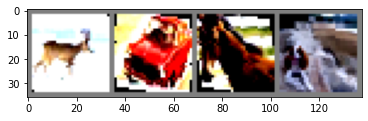

In [ ]:
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
from resnet import ResNet18
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("device: ",device)
model = ResNet18().to(device)

device:  cuda


In [ ]:
from torchsummary import summary
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.optim as optim
from cifar10_trainer import ModelTrainer
import torch.nn.functional as F
import torch.nn as nn

criterion = nn.CrossEntropyLoss()


root_path = r"/content/gdrive/MyDrive/EVA5/S8AssignmentSolution"

EPOCHS = 20
train_test_history ={}

model = ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=200)
model_trainer = ModelTrainer()
  
for epoch in range(1,EPOCHS+1):
  print("EPOCH:", epoch)
  model_trainer.train(model, device, train_loader, optimizer, epoch, criterion, l1_penalty=0)
  scheduler.step()
  model_trainer.test(model, device, test_loader, criterion)

  train_test_history[epoch] = {
      "train_losses": model_trainer.train_losses,
      "test_losses": model_trainer.test_losses,
      "train_accuracies": model_trainer.train_acc,
      "test_accuracies": model_trainer.test_acc
  }
  # save model weights after every 50 epochs
  if epoch%10 == 0:
    model_file_name = f"cifar_10_epoch_{epoch}.pth"
    model_path =f"{root_path}/{model_file_name}"
    torch.save(model.state_dict(), model_path)
    print(f"Saving the model for at {model_path}.")

EPOCH: 1
Train set: Average loss: 0.0148, Accuracy: 23172/50000 (46.34%)
Test set: Average loss: 0.0131, Accuracy: 5251/10000 (52.51%)
EPOCH: 2
Train set: Average loss: 0.0101, Accuracy: 32137/50000 (64.27%)
Test set: Average loss: 0.0076, Accuracy: 7338/10000 (73.38%)
EPOCH: 3
Train set: Average loss: 0.0081, Accuracy: 35738/50000 (71.48%)
Test set: Average loss: 0.0067, Accuracy: 7668/10000 (76.68%)
EPOCH: 4
Train set: Average loss: 0.0071, Accuracy: 37745/50000 (75.49%)
Test set: Average loss: 0.0066, Accuracy: 7706/10000 (77.06%)
EPOCH: 5
Train set: Average loss: 0.0063, Accuracy: 39025/50000 (78.05%)
Test set: Average loss: 0.0063, Accuracy: 7949/10000 (79.49%)
EPOCH: 6
Train set: Average loss: 0.0058, Accuracy: 39795/50000 (79.59%)
Test set: Average loss: 0.0050, Accuracy: 8286/10000 (82.86%)
EPOCH: 7
Train set: Average loss: 0.0053, Accuracy: 40695/50000 (81.39%)
Test set: Average loss: 0.0051, Accuracy: 8298/10000 (82.98%)
EPOCH: 8
Train set: Average loss: 0.0049, Accuracy: 413

In [ ]:
import json

with open(f"{root_path}/train_test_metrics.json", "w") as outfile:  
    json.dump(train_test_history, outfile)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


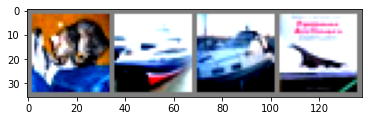

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
# images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images[0:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

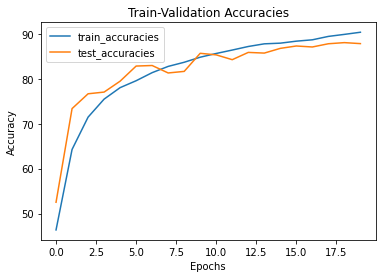

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_test_history[20]["train_accuracies"],label="train_accuracies")
ax.plot(train_test_history[20]["test_accuracies"],label="test_accuracies")
leg = ax.legend()
  
plt.title('Train-Validation Accuracies')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig(f'{root_path}/accuracy_plot.png')

## Measuring classwise accuracies

In [6]:
model = ResNet18().to(device)
model.load_state_dict(torch.load("/content/gdrive/MyDrive/EVA5/S8AssignmentSolution/cifar_10_epoch_20.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [10]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 95 %
Accuracy of   car : 100 %
Accuracy of  bird : 60 %
Accuracy of   cat : 83 %
Accuracy of  deer : 87 %
Accuracy of   dog : 68 %
Accuracy of  frog : 94 %
Accuracy of horse : 93 %
Accuracy of  ship : 91 %
Accuracy of truck : 96 %
